Simple aperture photometry for WFC3/UVIS.

You'll need the pixel area maps from here https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/pixel-area-maps

And the encircled energy table from here https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-encircled-energy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Modify the paths below to point to your data, enircled energy table and pams directory.

In [2]:
path = '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/' #path to the data directory
eetab = Table.read('{}../../wfc3uvis2_aper_007_syn.csv'.format(path)) #ee table
pamspath = '{}../../pams/'.format(path) # pam directory.

drcs are combined images with cosmic rays removed. flc are individual exposures.

In [4]:
drcs = glob.glob('{}*drc.fits'.format(path))
drcs

['/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01010_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01041_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01051_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01020_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01031_drc.fits']

In [5]:
flcs = glob.glob('{}*flc.fits'.format(path))
flcs

['/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i0q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i1q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01iaq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i3q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i4q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i6q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i7q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i8q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i2q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i5q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01hzq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i9q_flc.fits']

In [6]:
#this just lists some meta data for reference 

roots = []
bands = []
times = []
expt = []
dates = []
starts = []
datasets = [] 
for drc in drcs:
    hdr = fits.getheader(drc, 0)
    roots.append(hdr['ROOTNAME'])
    bands.append(hdr['FILTER'])
    times.append(hdr['EXPSTART'])
    expt.append(hdr['EXPTIME'])
    dates.append(hdr['DATE-OBS'])
    datasets.append(hdr['ROOTNAME'])
roots, bands, times, expt,  dates, datasets = np.array(roots), np.array(bands), np.array(times), np.array(expt), np.array(dates), np.array(datasets)    
drcargs = np.argsort(times)
roots, bands, times, expt, dates, datasets = roots[drcargs], bands[drcargs], times[drcargs], expt[drcargs], dates[drcargs], datasets[drcargs] 

[print(r, b, t ,e) for r, b, t, e in zip(roots, bands, times, expt)]

#    Date & Instrument & Filter & Start Time (MJD) & Exposure Time (s) & Exposure Name & Dataset \\ 

# for i in range(len(flcs)):
#     print('{} & WFC3/UVIS & {} & {} & {} & {} & {} \\\\'.format(dates[i], bands[i], times[i], expt[i], roots[i], datasets[i]))

if3i01010_drc.fits F275W 60115.74853343 1770.0
if3i01020_drc.fits F280N 60115.75671639 1770.0
if3i01031_drc.fits F225W 60115.7649338 1180.0
if3i01041_drc.fits F225W 60115.8310912 1180.0
if3i01051_drc.fits F225W 60115.89713306 1180.0


[None, None, None, None, None]

First we'll get photometry from the dlc files...

5.128205128205129
/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01010_drc.fits
F275W
1770.0
   aperture_sum   
------------------
1.2972315777307615
5.452135430163548e-18 1.119714038477634e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1   489.8   751.7        1.297          0.02707  -0.02097               1.318


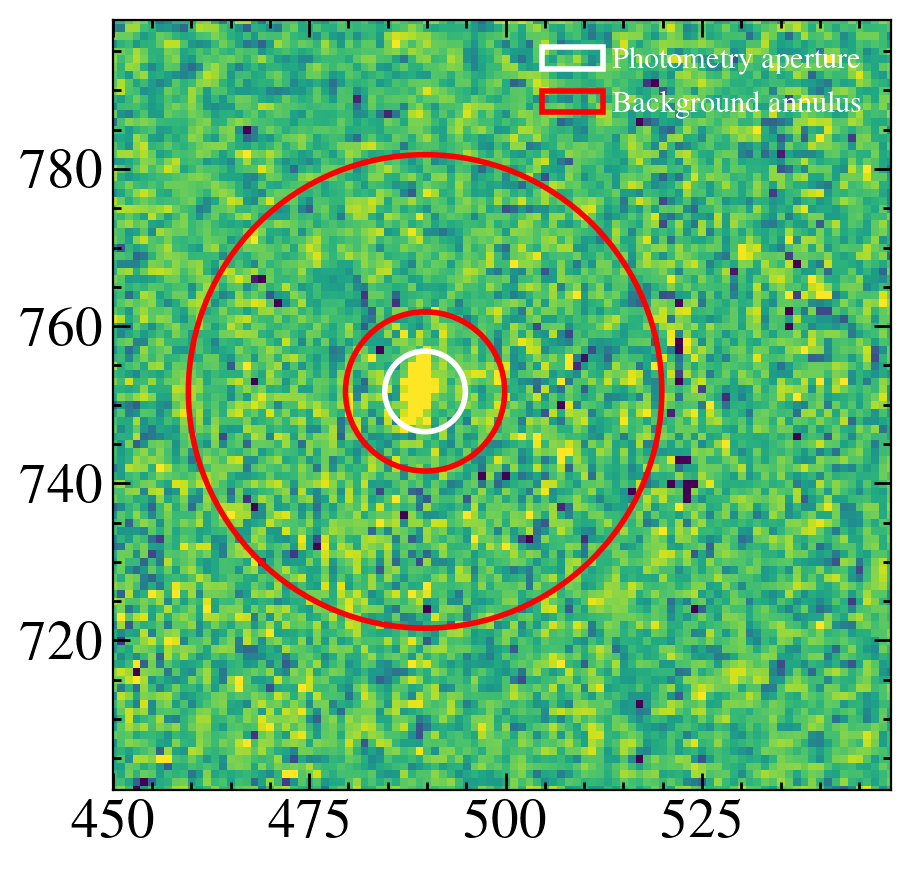

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01020_drc.fits
F280N
1770.0
   aperture_sum   
------------------
0.7843437268321656
5.126904013331354e-17 1.5297677866316075e-18
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1   489.8   751.7       0.7843          0.02105   0.07884              0.7055


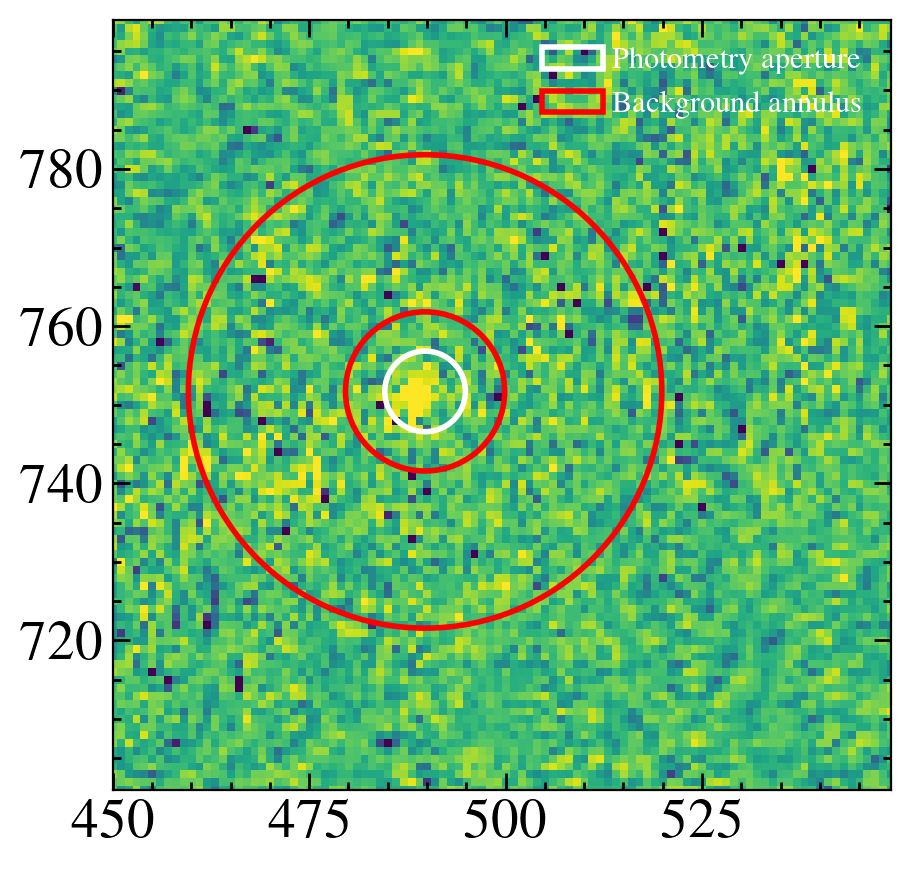

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01031_drc.fits
F225W
1180.0
   aperture_sum   
------------------
0.8320296722898983
4.958936958880467e-18 1.583516615679441e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1   489.8   751.7        0.832          0.02655 0.0004682              0.8316


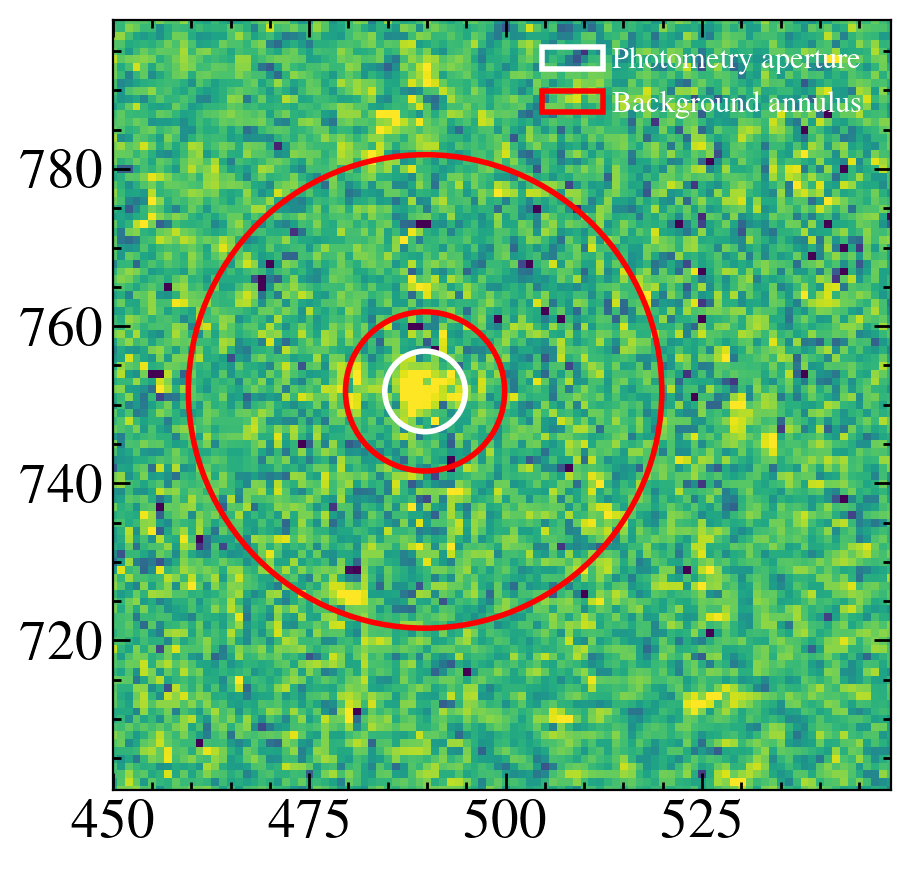

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01041_drc.fits
F225W
1180.0
    aperture_sum   
-------------------
0.44531551241464473
2.528341647072167e-18 1.1584765844502505e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1   489.8   751.7       0.4453          0.01943   0.02134               0.424


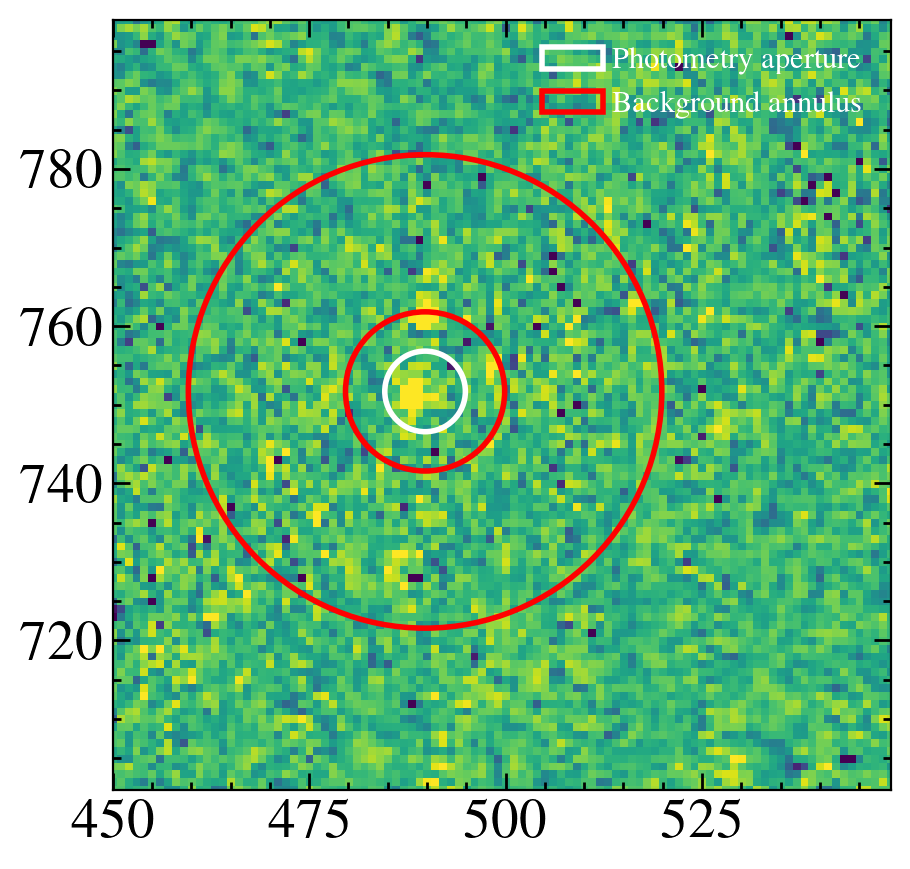

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01051_drc.fits
F225W
1180.0
   aperture_sum   
------------------
0.8851534882012018
5.1179708179262735e-18 1.6332880358261916e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1   489.8   751.7       0.8852          0.02739   0.02692              0.8582


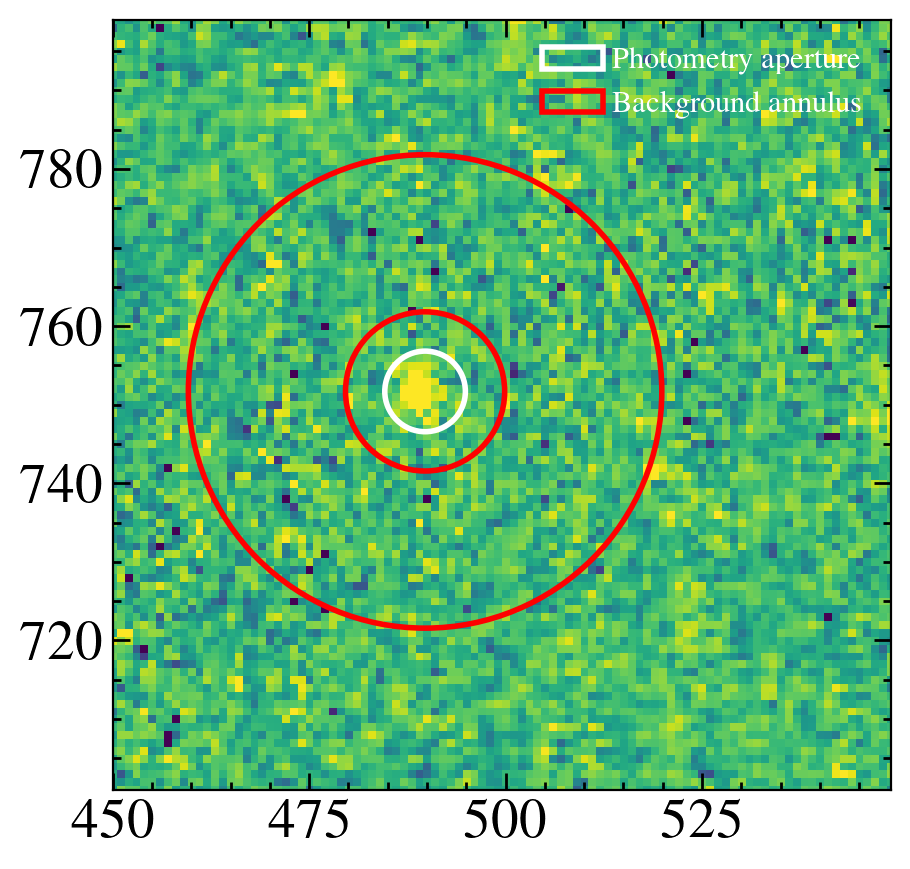

In [7]:
wfc3_pos = [(489.752, 751.70)] #modify this to the location of the source in your images (in pixels)
pixscale = 0.039
ap_arc = '0.20' # aperture size in arcseconds
ap_pix = float(ap_arc)/pixscale #aperture size in pixels

print(ap_pix)

filters = []
fluxes = []
flux_errs = []
starts = []
ends = []
counts = []
counts_errs = []
bkgs = []

drcsort = np.array(drcs)[drcargs]
for drc in drcsort:
    print(drc)
    hdul = fits.open(drc)
    filt = hdul[0].header['FILTER'] 
    print(filt)
    filters.append(filt)
    exptime = hdul[0].header['EXPTIME']
    starts.append(hdul[0].header['EXPSTART'])
    ends.append(hdul[0].header['EXPEND'])
    
    print(exptime)
    data = hdul[1].data
    data = np.nan_to_num(data, 0.0)
    
    norm = simple_norm(data, 'sqrt', percent=99)
    plt.imshow(data, norm=norm, interpolation='nearest', origin='lower')
    plt.xlim(450, 549)
    plt.ylim(701, 799)




    aperture = CircularAperture(wfc3_pos, r=ap_pix)

    annulus_aperture = CircularAnnulus(wfc3_pos, r_in=ap_pix+5, r_out=ap_pix+25)

    ap_patches = aperture.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annulus_aperture.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    
    phot_table = aperture_photometry(data, aperture)
#     print(phot_table)
    aperture_area = aperture.area_overlap(data)
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
    total_bkg = bkg_stats.median * aperture_area
    print(phot_table['aperture_sum'])
    phot_error = ((phot_table['aperture_sum']*exptime)**0.5)/exptime#calculating error by hand
    phot_table['aperture_sum_err'] = phot_error
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.4g'  # for consistent table output
        
    ee = eetab['APER#{}'.format(ap_arc)][eetab['FILTER'] == filt][0]
#     print(ee[0])
    
    photflam = hdul[1].header['PHOTFLAM']
    
    flux = phot_table['aperture_sum_bkgsub'][0] * photflam /ee #convert to flux units and adjust by encircled energy
    flux_err = phot_table['aperture_sum_err'][0]* photflam /ee
    print(flux, flux_err)
    
    fluxes.append(flux)
    flux_errs.append(flux_err)
    
    counts.append(phot_table['aperture_sum_bkgsub'])
    counts_errs.append(phot_table['aperture_sum_err'])
    bkgs.append(phot_table['total_bkg'])

    print(phot_table)
    
    
    
    
    
    
    

    plt.show()
    
starts, ends = np.array(starts), np.array(ends)


#modify the lines below to save the data however you want.

# savdat = Table([starts, ends, expt, bands, fluxes*u.erg/u.s/u.cm**2/u.AA, flux_errs*u.erg/u.s/u.cm**2/u.AA, roots,counts ,counts_errs,bkgs], 
#                names = ['EXPSTART', 'EXPEND', 'EXPTIME', 'FILTER', 'FLUX', 'ERROR', 'ROOTNAME', 'COUNTS', 'COUNTS_ERROR', 'BACKGROUND'])
# savdat.write('results/epoch{}_wfc3_drc_photometry.ecsv'.format(epoch), format='ascii.ecsv', overwrite=True)

Now let's get photometry from the individual FLC files. We have to muliplty the files by the pixel area maps (PAMS). Also, carefully inspect the individual images to make sure that there are no cosmic ray hits near the centre of the aperture. Images where this happens should be discarded. 

In [8]:
flcs

['/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i0q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i1q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01iaq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i3q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i4q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i6q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i7q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i8q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i2q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i5q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01hzq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i9q_flc.fits']

In [9]:
def make_PAMcorr_image_UVIS(data, scihdr, pamdir):
    """
    Corrects the geometric distortion of the input image
    data by multiplying by the correct UVIS PAM.
    Parameters
    ----------
    data : array
        Image data before correction.
    scihdr : header
        Header from science extension of data.
    pamdir : str
        Path to where pixel area maps for UVIS1 and/or
        UVIS2 are located.
    Returns
    -------
    pamcorr_data : array
        PAM-corrected data.
    """

    data = np.copy(data)
    x0 = int(np.abs(scihdr['LTV1']))
    y0 = int(np.abs(scihdr['LTV2']))
    x1 = int(x0 + scihdr['NAXIS1'])
    y1 = int(y0 + scihdr['NAXIS2'])
    

    if scihdr['CCDCHIP'] == 1:
        pam = fits.getdata(pamdir + 'UVIS1wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]

    elif scihdr['CCDCHIP'] == 2:
        pam = fits.getdata(pamdir + 'UVIS2wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]
    else:
        raise Exception('Chip case not handled.')

    return pamcorr_data

In [10]:
roots = []
bands = []
times = []
expt = []
dates = []
starts = []
datasets = [] 
for flc in flcs:
    hdr = fits.getheader(flc, 0)
    roots.append(hdr['ROOTNAME'])
    bands.append(hdr['FILTER'])
    times.append(hdr['EXPSTART'])
    expt.append(hdr['EXPTIME'])
    dates.append(hdr['DATE-OBS'])
    datasets.append(hdr['ASN_ID'])
roots, bands, times, expt,  dates, datasets = np.array(roots), np.array(bands), np.array(times), np.array(expt), np.array(dates), np.array(datasets)    
args = np.argsort(times)
roots, bands, times, expt, dates, datasets = roots[args], bands[args], times[args], expt[args], dates[args], datasets[args] 

[print(r, b, t ,e) for r, b, t, e in zip(roots, bands, times, expt)]

#    Date & Instrument & Filter & Start Time (MJD) & Exposure Time (s) & Exposure Name & Dataset \\ 

# for i in range(len(flcs)):
#     print('{} & WFC3/UVIS & {} & {} & {} & {} & {} \\\\'.format(dates[i], bands[i], times[i], expt[i], roots[i], datasets[i]))

if3i01hzq F275W 60115.74853343 590.0
if3i01i0q F280N 60115.75671639 590.0
if3i01i1q F225W 60115.7649338 590.0
if3i01i2q F225W 60115.77288528 590.0
if3i01i3q F275W 60115.81469083 590.0
if3i01i4q F280N 60115.8228738 590.0
if3i01i5q F225W 60115.8310912 590.0
if3i01i6q F225W 60115.83904269 590.0
if3i01i7q F275W 60115.88073269 590.0
if3i01i8q F280N 60115.88891528 590.0
if3i01i9q F225W 60115.89713306 590.0
if3i01iaq F225W 60115.90508454 590.0


[None, None, None, None, None, None, None, None, None, None, None, None]

Redoing photometry with flc files 

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01hzq_flc.fits
F275W
[0.25571495]
[5.38541089]
[71.10132002]
[18.1816707] [382.90982291]
4.856504531583796e-18 3.4612059264421706e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720          711            49.37     18.18               692.8


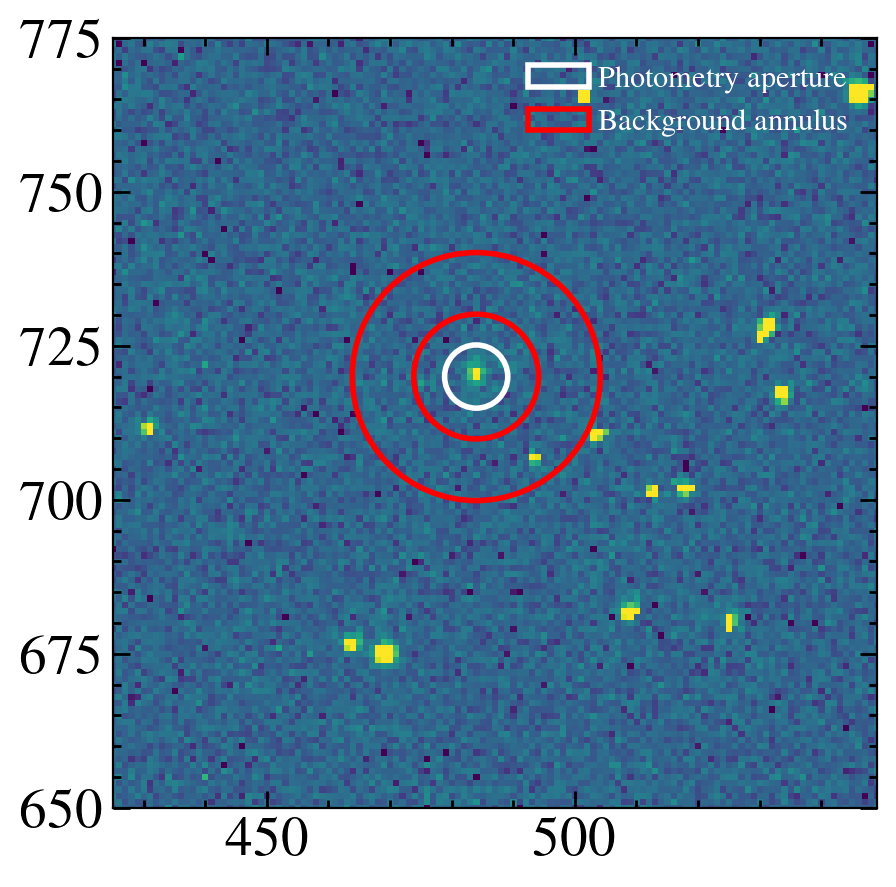

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i0q_flc.fits
F280N
[0.16609845]
[5.56319923]
[73.10086562]
[12.14194016] [406.67467928]
5.2461960998673604e-17 5.737192227251236e-18
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        438.1            46.58     12.14               425.9


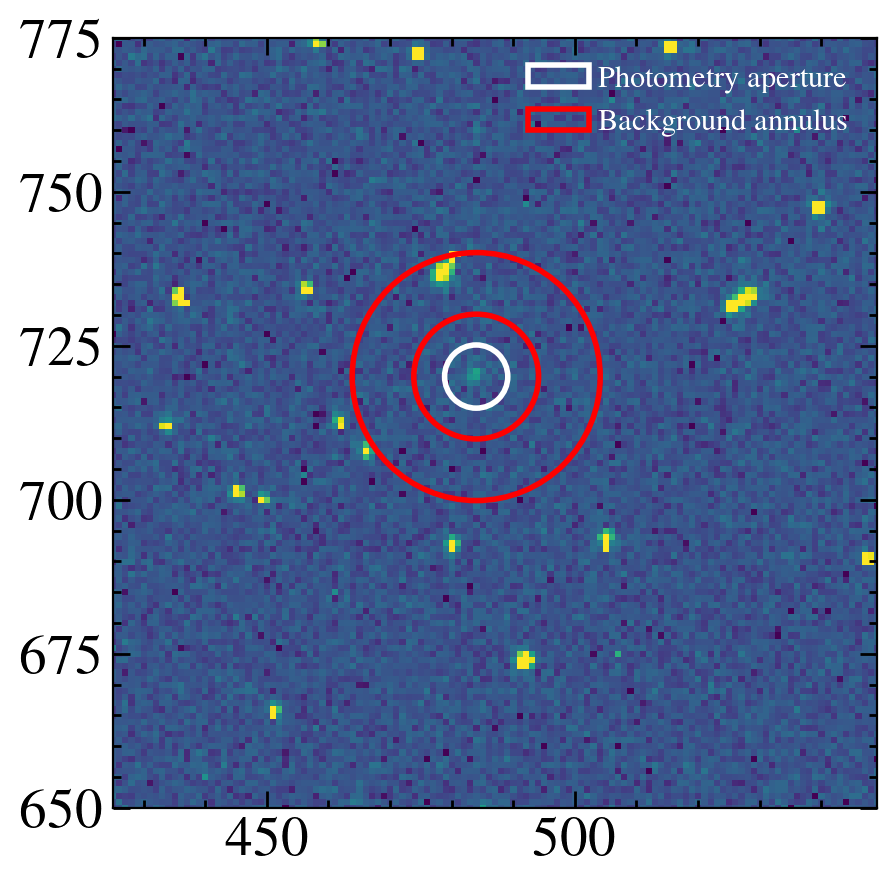

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i1q_flc.fits
F225W
[0.74441451]
[4.93305691]
[73.10086562]
[54.41734494] [360.61073049]
4.693104769963343e-18 4.173187298679815e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        518.7            41.29     54.42               464.3


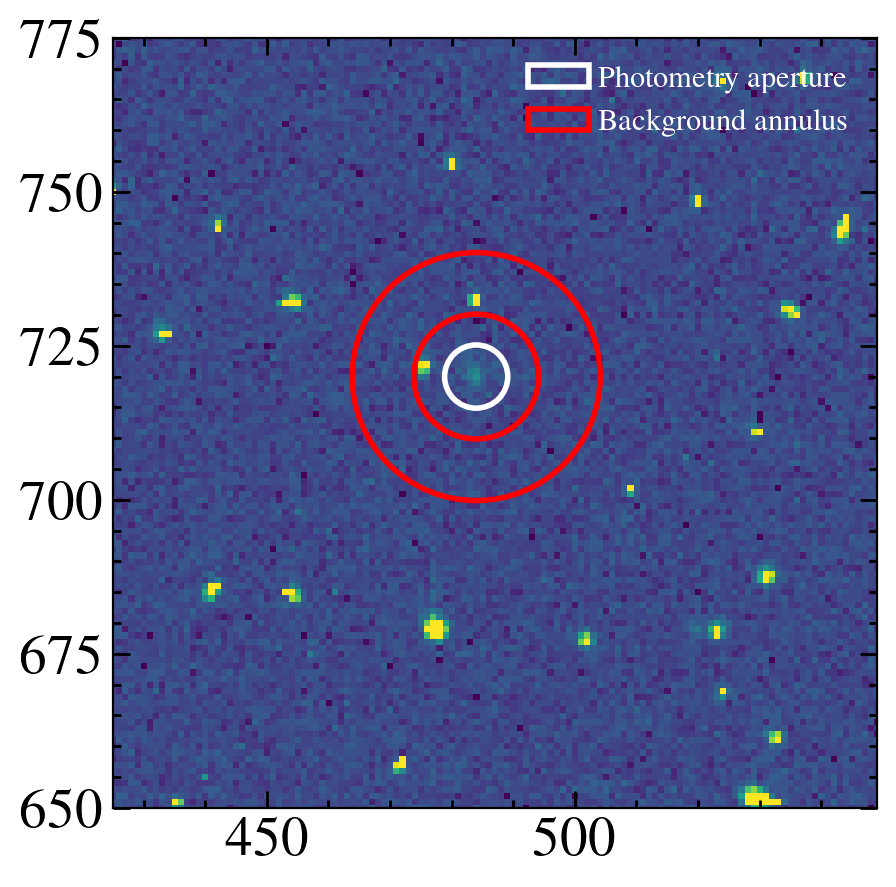

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i2q_flc.fits
F225W
[-0.56096643]
[4.84851417]
[65.58018664]
[-36.78828332] [317.96646405]
3.88067809312641e-18 3.8610440202670692e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        347.2             38.2    -36.79               383.9


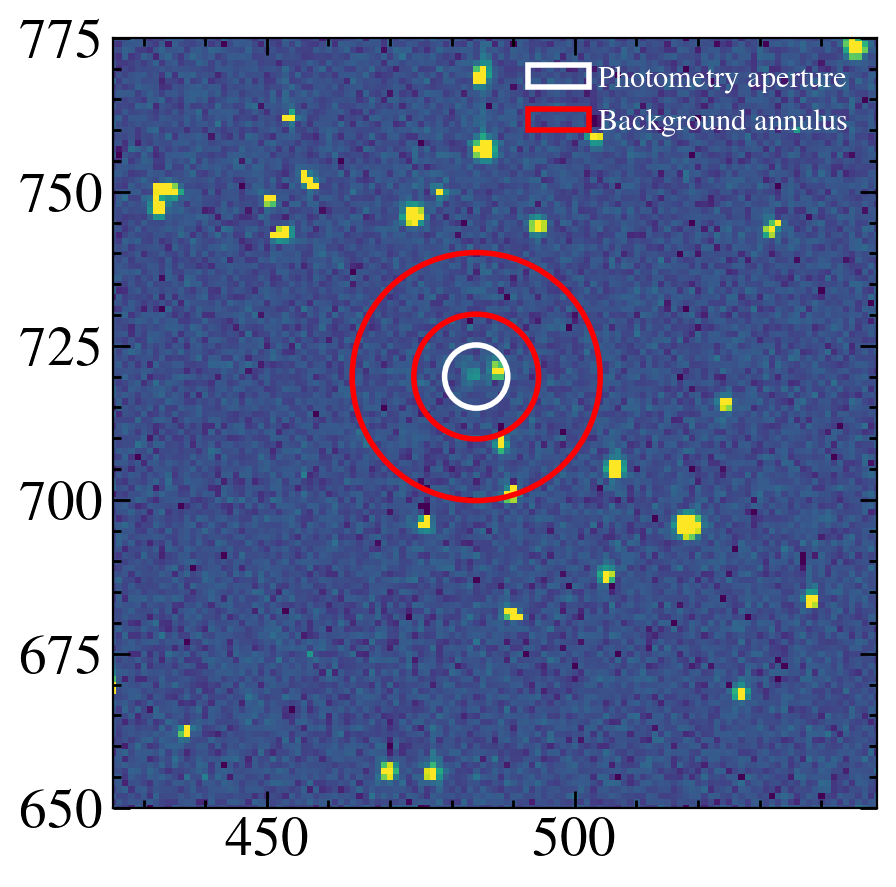

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i3q_flc.fits
F275W
[0.4076121]
[5.56973146]
[73.06937865]
[29.78396289] [406.97681684]
4.654884239245067e-18 3.4950625569488864e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        693.8            49.86     29.78                 664


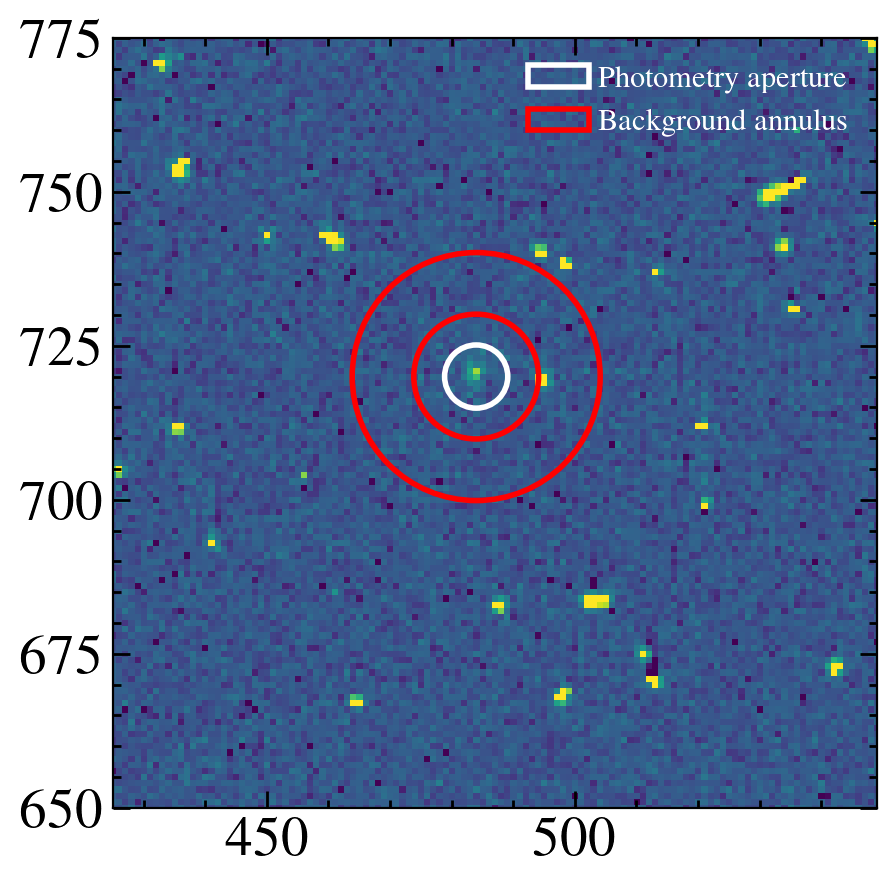

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i4q_flc.fits
F280N
[0.76245469]
[5.84991688]
[71.36804481]
[54.41490038] [417.49713019]
4.836471827357364e-17 5.651625930104849e-18
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        447.1            45.88     54.41               392.7


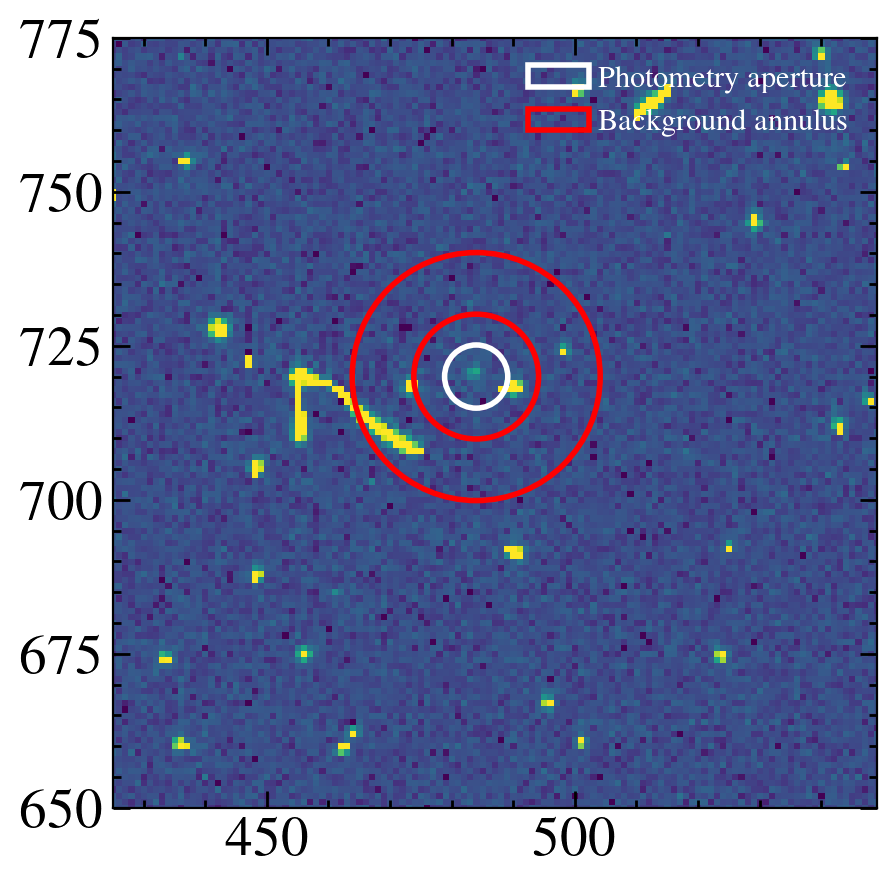

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i5q_flc.fits
F225W
[0.20577134]
[4.90314181]
[73.10086562]
[15.04206321] [358.42391062]
2.9226896271125003e-18 3.9944864986826136e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        304.2            39.52     15.04               289.2


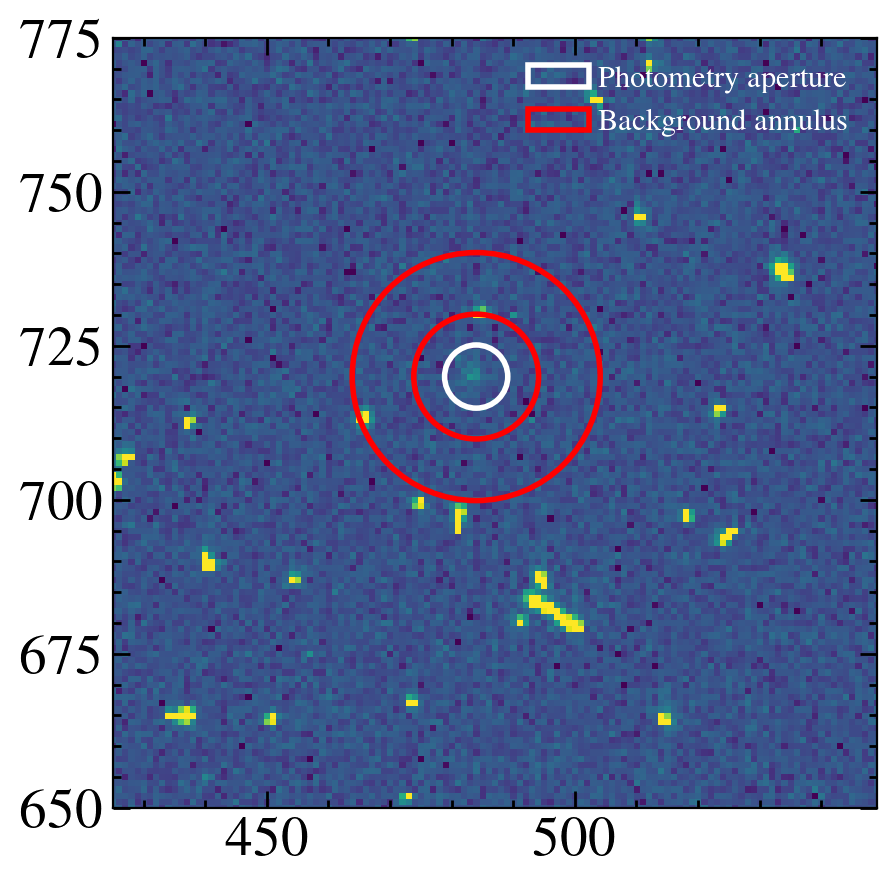

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i6q_flc.fits
F225W
[-0.20431689]
[4.95755464]
[73.10086562]
[-14.93574165] [362.40153543]
2.3151216659683107e-18 3.8637362217757783e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        214.1            38.23    -14.94               229.1


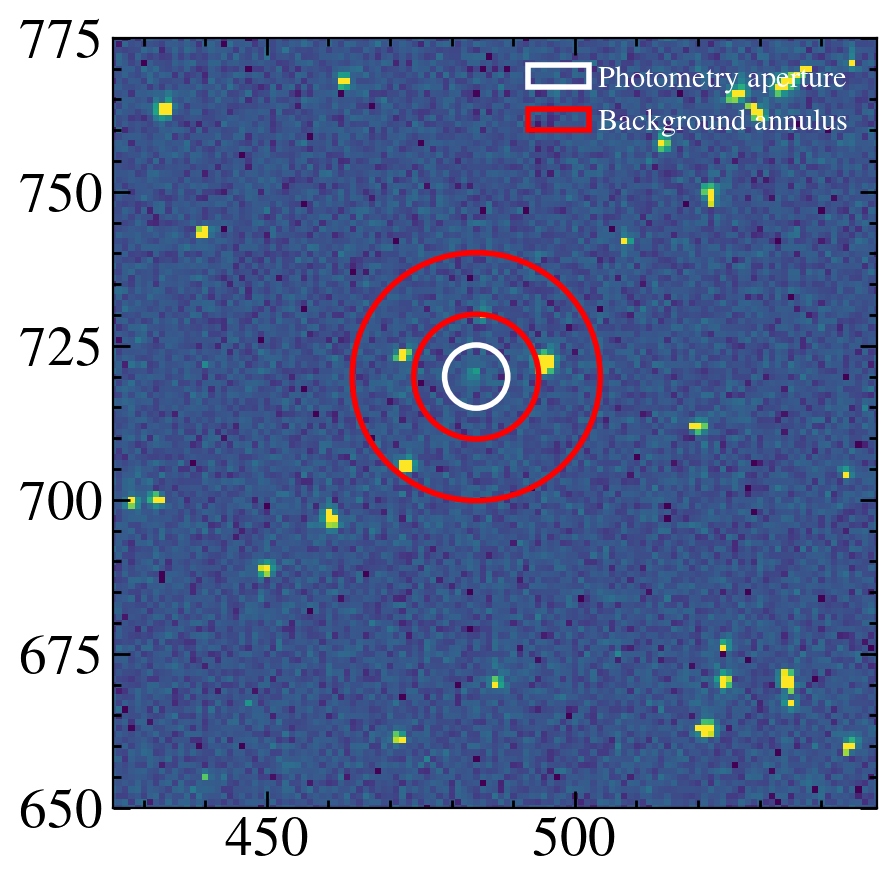

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i7q_flc.fits
F275W
[0.37077732]
[5.37374647]
[73.10086562]
[27.10414333] [392.82551882]
4.549613832406969e-18 3.457999874619021e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        676.1            49.33      27.1                 649


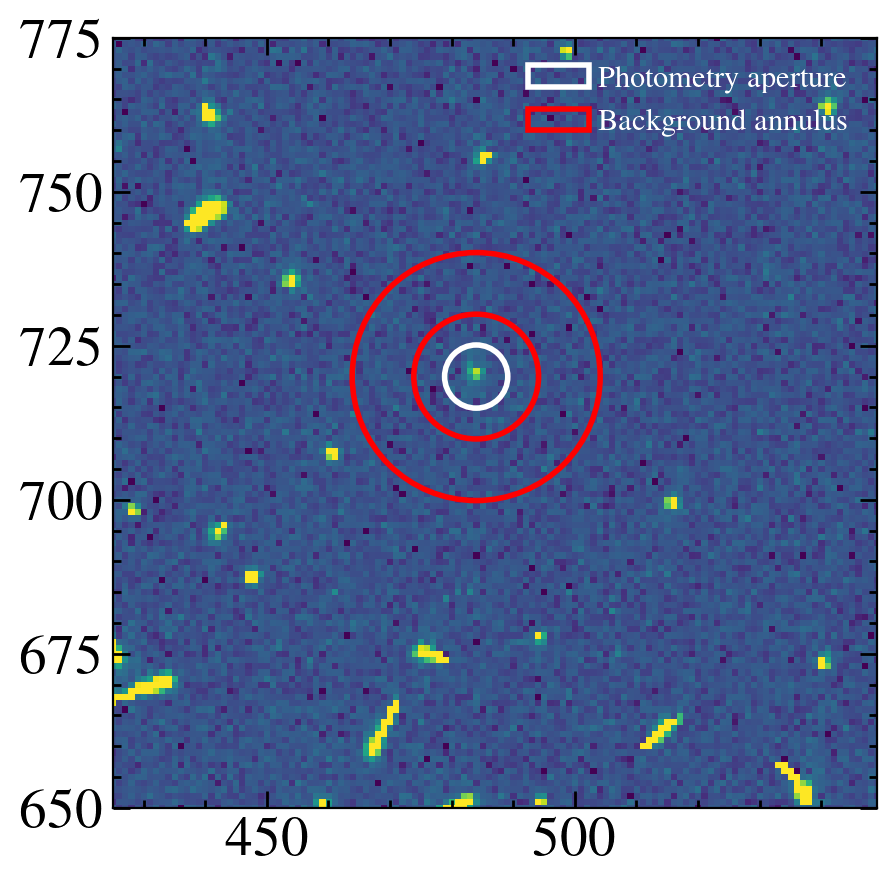

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i8q_flc.fits
F280N
[0.90662876]
[5.47449627]
[73.10086562]
[66.27534699] [400.190416]
4.207279453534473e-17 5.714202010879351e-18
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        407.9            46.39     66.28               341.6


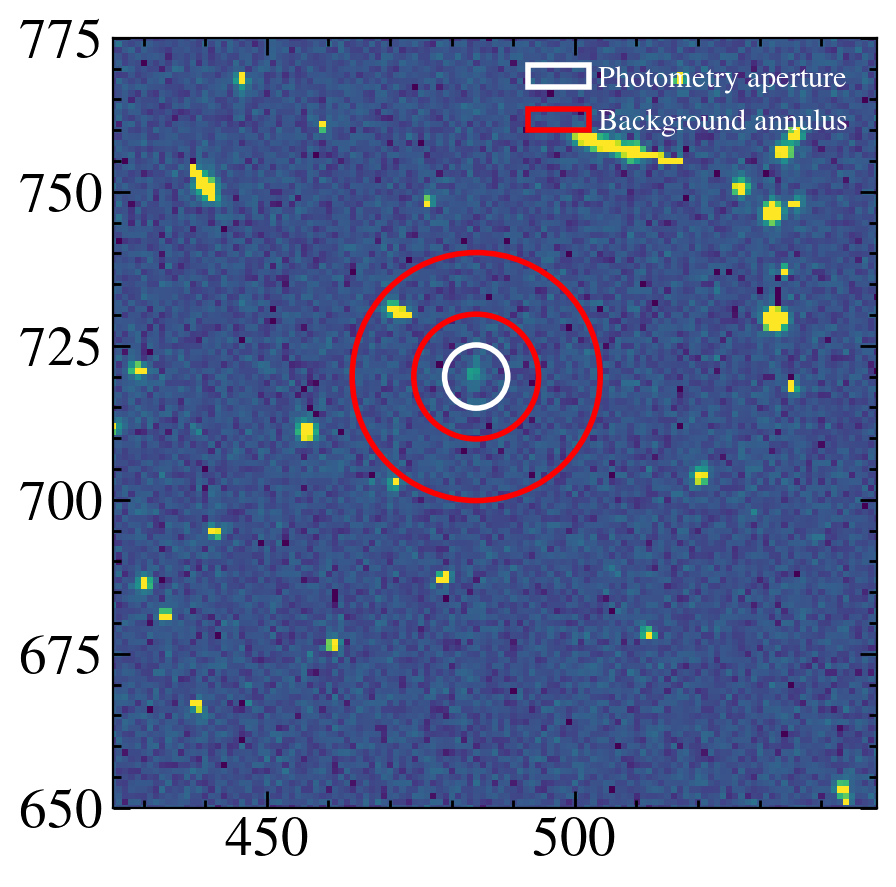

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01i9q_flc.fits
F225W
[0.75880569]
[4.68262975]
[73.10086562]
[55.46935294] [342.30428781]
2.8214378971501346e-18 3.9869427451802825e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        334.6            39.45     55.47               279.1


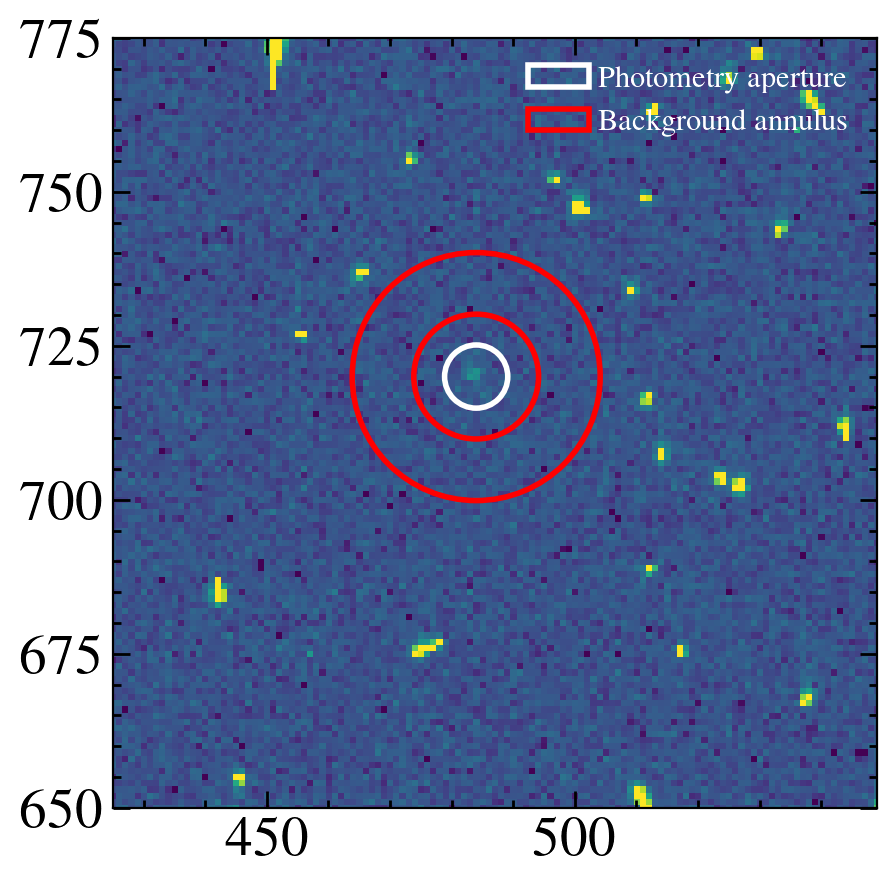

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch1/wfc3/if3i01iaq_flc.fits
F225W
[-0.52356064]
[4.97932965]
[70.10086562]
[-36.70205429] [349.05531893]
5.936687471633792e-18 4.169055562005116e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     484     720        550.7            41.25     -36.7               587.4


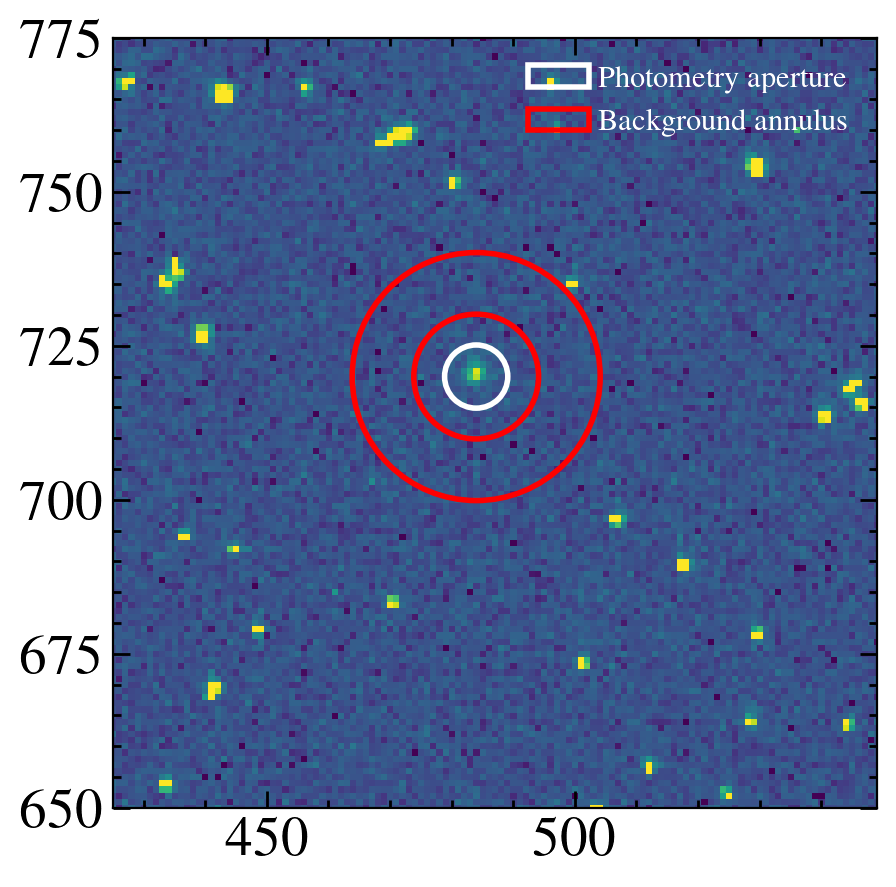

In [11]:
# wfc3_pos = [(489.752, 751.70)]
wfc3_pos = [(484, 720)]
bkpos = [(480,750), (505, 735), (510, 730),(460, 720), (460, 720), (480, 750), (480, 750), (480, 750), (1, 1),(510, 730), (1, 1), (1,1) ] #1 = use annulus
pixscale = 0.039
ap_arc = '0.20' # aperture size in arcseconds
ap_pix = float(ap_arc)/pixscale #aperture size in pixels

filters = []
fluxes = []
flux_errs = []
starts = []
ends = []
counts = []
counts_errs = []
bkgs = []
# print(eetab['APER#{}'.format(ap_arc)])

# for flc in flcs:
#     print(flc)
#     hdul = fits.open(flc)
flcsort = np.array(flcs)[args]
for i, flc in enumerate(flcsort):
    print(flc)
    hdul = fits.open(flc)
    filt = hdul[0].header['FILTER'] 
    print(filt)
    filters.append(filt)
    exptime = hdul[0].header['EXPTIME']
    starts.append(hdul[0].header['EXPSTART'])
    ends.append(hdul[0].header['EXPEND'])
    
#     print(exptime)
    data = hdul[1].data
    data = make_PAMcorr_image_UVIS(data, hdul[1].header, pamspath) #corrects the data using the PAM
#     data = np.nan_to_num(data, 0.0)
    error = hdul[2].data
    dq = hdul[3].data
    mask = (dq != 0) 
#     error = np.sqrt(data*exptime)/exptime
    
    norm = simple_norm(data, 'sqrt', percent=99)
    plt.imshow(data, norm=norm, interpolation='nearest', origin='lower')
    plt.xlim(425, 549)
    plt.ylim(650, 775)
# # positions = [(515, 509), (725, 468)]



    aperture = CircularAperture(wfc3_pos, r=ap_pix)
    annulus_aperture = CircularAnnulus(wfc3_pos, r_in=ap_pix+5, r_out=ap_pix+15)
    
#     if bkpos[i][0] == 1:
#         annulus_aperture = CircularAnnulus(wfc3_pos, r_in=ap_pix+5, r_out=ap_pix+15)
#     else:
#         annulus_aperture = CircularAperture(bkpos[i], r=15)

    ap_patches = aperture.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annulus_aperture.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    
    phot_table = aperture_photometry(data, aperture, error=error, mask=mask)
#     print(phot_table)
    aperture_area = aperture.area_overlap(data, mask=mask)
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip, error=error, mask=mask)
    print(bkg_stats.median)
    print(bkg_stats.std)
    print(aperture_area)
    total_bkg = bkg_stats.median * aperture_area[0]
    bkg_err = bkg_stats.std * aperture_area[0]
    print(total_bkg, bkg_err)
#     print(phot_table['aperture_sum'])
#     phot_error = ((phot_table['aperture_sum']*exptime)**0.5)/exptime#calculating error by hand
#     phot_table['aperture_sum_err'] = phot_error
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.4g'  # for consistent table output
        
    ee = eetab['APER#{}'.format(ap_arc)][eetab['FILTER'] == filt][0]
#     print(ee[0])
    
    photflam = hdul[1].header['PHOTFLAM']
    
    flux = phot_table['aperture_sum_bkgsub'][0] * photflam / (ee *exptime)
    flux_err = phot_table['aperture_sum_err'][0]* photflam / (ee *exptime)
    print(flux, flux_err)
    
    fluxes.append(flux)
    flux_errs.append(flux_err)

    print(phot_table)
    counts.append(phot_table['aperture_sum_bkgsub'])
    counts_errs.append(phot_table['aperture_sum_err'])
    bkgs.append(phot_table['total_bkg'])

    
    
    
    
    
    
    

    plt.show()
    
starts, ends = np.array(starts), np.array(ends)



# savdat = Table([starts, ends, expt, bands, fluxes*u.erg/u.s/u.cm**2/u.AA, flux_errs*u.erg/u.s/u.cm**2/u.AA, roots,counts ,counts_errs,bkgs], 
#                names = ['EXPSTART', 'EXPEND', 'EXPTIME', 'FILTER', 'FLUX', 'ERROR', 'ROOTNAME', 'COUNTS', 'COUNTS_ERROR', 'BACKGROUND'])
# savdat.write('results/epoch{}_wfc3_photometry.ecsv'.format(epoch), format='ascii.ecsv', overwrite=True)

In [12]:
# eetab

In [13]:
# fig, ax = plt.subplots()
# names = eetab.dtype.names
# # print(names[2:])
# apers = names[2:]
# w = eetab['WAVELENGTH']

# for aper in apers:
#     ax.plot(w, eetab[aper], alpha=0.5)